# A transdimensional piecewise constant regression
This script recreates the piecewise constant regression example presented in "*Transdimensional inference in the geosciences*" paper (Sambridge et al. 2013) using **transdimensional inversion with a Voronoi nuclei parameterization**.

Through a **random initial prior model, observed data, and RJMCMC iterations**, perturbations as **moves, births and deaths** of Voronoi nuclei are proposed to explore the model space and converge to likely solutions in different dimensions. At the end, it is possible to extract a **smooth mean model** that aims to fit the true model as fine as possible.

The **y** coordinate of model partitions is the parameter of interest in the Bayesian inversion. The model dimension **k** concerns the number of model partitions, each being defined by a Voronoi nucleus.
$$ 
\alpha = \frac{1}{\exp ^2}
$$
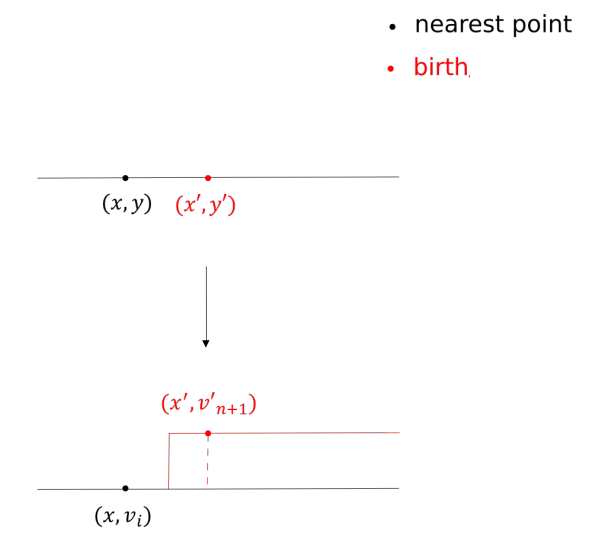

In [ ]:
# Load modules
from TransD_regression import *

### True model building

We first compute a **piecewise constant function** with nine partitions (thick piecewise constant line) according to the paper cited above. For simplicity, the dimensions and coordinates of the change points are the same as in the article, but it would be possible to take another configuration. The function is considered as the **true model**, and we are looking in this work for a mean to recover this model from random data.

In [ ]:
# Field boundaries
x_min = 0
x_max = 10
y_min = -60
y_max = 60
boundaries = np.array(([x_min, y_min], [x_max, y_max]))

# Create observed data from the solution
compute_true_model()
plot_result(boundaries)

### Observed data creation from the true model

The observed data that will be used in the inversion process are some **dots** from the true model sampled with a given step and **contaminated with Gaussian random noise** with a given standard deviation in the y-direction. Here, we chose a step of 0.1 which means 100 points are sampled along the x-axis.

The problem is to reconstruct the thick piecewise constant line from the dots

In [ ]:
x_dobs = []  # x coordinates of observed data
y_dobs = []  # y coordinates of observed data
sigma = 10.  # standard deviation parameter
create_noisy_points(sigma, x_dobs, y_dobs)

# Plot
compute_true_model()
plt.scatter(x_dobs, y_dobs, c='orange', label='observed data')
plot_result(boundaries)

### Initial model building

A transdimensional sampling is based on bayesian Monte Carlo with a Markov chain. It involves the use of a starting model for the chain. The model parametrization is built from zeroth-order polynomials, i.e. simple constants within an unknown number of partitions.

For yi (i = 1, . . . np ) the prior ranges between the limits of the observations, for xi (i = 1, . . . np ) the prior ranges between 0 and 10, and for np
between 1 and 50.

Since the noise statistics are i.i.d. Gaussian random variables then the likelihood
is given by

In [ ]:
# Build initial model
npa_min = 1  # min number of partitions (> 0)
npa_max = 50  # max number of partitions
initial_model = Model()
initial_model.build_initial_model(boundaries, y_dobs, npa_min, npa_max)
print("initial model:\nx =", initial_model.x, "\ny =", initial_model.y, "\nnumber of partitions =",
      initial_model.npa)
initial_model.compute_phi(sigma, x_dobs, y_dobs)  # initial model misfit

# Plot
initial_model.draw_lines(boundaries, 'b')
plt.scatter(x_dobs, y_dobs, c='orange', label='observed data')
plt.scatter(initial_model.x, initial_model.y, c='blue', marker='s', label='initial model')
plot_result(boundaries)

In [ ]:
# Set RJMCMC variables
current_model = initial_model
burn_in = 10000  # length of the burn-in period
n_samples = 50000  # total number of samples
accepted_models = 0  # number of accepted models
rejected_models = 0  # number of rejected models
model_space = np.empty(n_samples - burn_in, dtype=Model)

for sample in range(n_samples):  # RJMCMC iterations
    # Build proposed model with a perturbation from current model
    proposed_model = Model()
    proposed_model.build_proposed_model(current_model, boundaries)

    # Compute prior of the proposed model (i.e. check if npa, x and y within bounds)
    prior = proposed_model.compute_prior(boundaries, y_dobs, npa_min, npa_max)
    if prior == 0:  # if out of bounds reject the proposition
        rejected_models += 1
        if sample >= burn_in:  # store current model in the chain if burn-in period has passed
            model_space[sample - burn_in] = current_model

    else:
        # Compute acceptance term and accept or reject it
        proposed_model.compute_phi(sigma, x_dobs, y_dobs)  # proposed model misfit
        u = np.random.random_sample()
        log_u = math.log(u)
        alpha = compute_acceptance(current_model, proposed_model, y_dobs)
        if alpha >= log_u:  # if accepted
            current_model = proposed_model
            accepted_models += 1
        else:  # if rejected
            rejected_models += 1

        # Collect models in the chain if burn-in period has passed
        if sample >= burn_in:
            model_space[sample - burn_in] = current_model

print("\naccepted models", accepted_models)
print("rejected models", rejected_models)
acceptance_rate = 100 * accepted_models / n_samples
print("acceptance rate", acceptance_rate)

In [ ]:
# Compute model number of partitions and extract best fit model
npa_number = compute_npa_numbers(model_space)
max_likelihood_model = extract_best_fit_model(model_space, sigma, x_dobs)

# Plot
max_likelihood_model.draw_lines(boundaries, 'green')
plt.scatter(x_dobs, y_dobs, c='orange', label='observed data')
plt.scatter(max_likelihood_model.x, max_likelihood_model.y, c='green', marker='s', label='best fit model')
plot_result(boundaries)

In [ ]:
# Take the mean model from model space
mean_model = Model()
mean_model.extract_mean_model(model_space)

# Plot
compute_true_model()
plt.scatter(mean_model.x, mean_model.y, c='purple', marker='o', label='mean model')
plot_result(boundaries)

In [ ]:
# Histograms of prior and posterior probabilities of model dimensions
plt.hist(npa_number, range=(npa_min, npa_max), density=True, color='purple',
         edgecolor='black', bins=(npa_max - npa_min), label='posterior PDF')
plt.hist(npa_max, range=(0, npa_max), density=True, color='cyan', bins=1, alpha=0.5,
         label='prior PDF')
plt.vlines(x=9, ymin=0, ymax=0.3, linewidth=2, color='r', label='true model dimension')
plt.xlabel('no. partitions')
plt.ylabel('frequency in posterior ensemble')
plt.legend(loc='upper right')
plt.title('p(np|d)')
plt.show()